In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [3]:
url = "https://raw.githubusercontent.com/Deepak2gr/ElectroTrends-India-EV-Sales-Analysis-Forecasting/main/Electric%20Vehicle%20Sales%20by%20State%20in%20India.csv"
df = pd.read_csv(url)
df

,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity
0,2014.0,jan,1/1/2014,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0
1,2014.0,jan,1/1/2014,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0
2,2014.0,jan,1/1/2014,Andhra Pradesh,AMBULANCE,Others,Others,0.0
3,2014.0,jan,1/1/2014,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0
4,2014.0,jan,1/1/2014,Andhra Pradesh,BUS,Bus,Bus,0.0
...,...,...,...,...,...,...,...,...
96840,2023.0,dec,12/1/2023,Andaman & Nicobar Island,MOTOR CAR,4-Wheelers,4W_Personal,1.0
96841,2023.0,dec,12/1/2023,Andaman & Nicobar Island,MOTOR CYCLE/SCOOTER-USED FOR HIRE,2-Wheelers,2W_Shared,5.0
96842,2023.0,dec,12/1/2023,Andaman & Nicobar Island,OMNI BUS,Bus,Bus,0.0
96843,2023.0,dec,12/1/2023,Andaman & Nicobar Island,THREE WHEELER (GOODS),3-Wheelers,3W_Goods,0.0


In [5]:
df.isnull().sum()

Year                 0
Month_Name           0
Date                 0
State                0
Vehicle_Class        0
Vehicle_Category     0
Vehicle_Type         0
EV_Sales_Quantity    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [9]:
df.describe()

,Year,EV_Sales_Quantity
count,96845.000000,96845.000000
mean,2018.622768,37.108896
std,2.895581,431.566675
min,2014.000000,0.000000
25%,2016.000000,0.000000
50%,2019.000000,0.000000
75%,2021.000000,0.000000
max,2024.000000,20584.000000


In [11]:
df.head(5)

,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity
0,2014.0,jan,1/1/2014,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0
1,2014.0,jan,1/1/2014,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0
2,2014.0,jan,1/1/2014,Andhra Pradesh,AMBULANCE,Others,Others,0.0
3,2014.0,jan,1/1/2014,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0
4,2014.0,jan,1/1/2014,Andhra Pradesh,BUS,Bus,Bus,0.0


In [13]:
# Display basic info about dataset
print("Shape of dataset:", df.shape)   # rows, columns
print("\nColumns in dataset:\n", df.columns.tolist())


Shape of dataset: (96845, 8)

Columns in dataset:
 ['Year', 'Month_Name', 'Date', 'State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type', 'EV_Sales_Quantity']


In [15]:
# Dataset info (datatypes, null values)
print("\nDataset Info:\n")
print(df.info())


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96845 entries, 0 to 96844
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               96845 non-null  float64
 1   Month_Name         96845 non-null  object 
 2   Date               96845 non-null  object 
 3   State              96845 non-null  object 
 4   Vehicle_Class      96845 non-null  object 
 5   Vehicle_Category   96845 non-null  object 
 6   Vehicle_Type       96845 non-null  object 
 7   EV_Sales_Quantity  96845 non-null  float64
dtypes: float64(2), object(6)
memory usage: 5.9+ MB
None


In [17]:
# Forward fill or mode fill for categorical columns
for col in ['State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type']:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])


In [19]:
df

,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity
0,2014.0,jan,1/1/2014,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0
1,2014.0,jan,1/1/2014,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0
2,2014.0,jan,1/1/2014,Andhra Pradesh,AMBULANCE,Others,Others,0.0
3,2014.0,jan,1/1/2014,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0
4,2014.0,jan,1/1/2014,Andhra Pradesh,BUS,Bus,Bus,0.0
...,...,...,...,...,...,...,...,...
96840,2023.0,dec,12/1/2023,Andaman & Nicobar Island,MOTOR CAR,4-Wheelers,4W_Personal,1.0
96841,2023.0,dec,12/1/2023,Andaman & Nicobar Island,MOTOR CYCLE/SCOOTER-USED FOR HIRE,2-Wheelers,2W_Shared,5.0
96842,2023.0,dec,12/1/2023,Andaman & Nicobar Island,OMNI BUS,Bus,Bus,0.0
96843,2023.0,dec,12/1/2023,Andaman & Nicobar Island,THREE WHEELER (GOODS),3-Wheelers,3W_Goods,0.0


In [21]:
# -----------------------------
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [23]:
df

,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity
0,2014.0,jan,2014-01-01,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0
1,2014.0,jan,2014-01-01,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0
2,2014.0,jan,2014-01-01,Andhra Pradesh,AMBULANCE,Others,Others,0.0
3,2014.0,jan,2014-01-01,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0
4,2014.0,jan,2014-01-01,Andhra Pradesh,BUS,Bus,Bus,0.0
...,...,...,...,...,...,...,...,...
96840,2023.0,dec,2023-12-01,Andaman & Nicobar Island,MOTOR CAR,4-Wheelers,4W_Personal,1.0
96841,2023.0,dec,2023-12-01,Andaman & Nicobar Island,MOTOR CYCLE/SCOOTER-USED FOR HIRE,2-Wheelers,2W_Shared,5.0
96842,2023.0,dec,2023-12-01,Andaman & Nicobar Island,OMNI BUS,Bus,Bus,0.0
96843,2023.0,dec,2023-12-01,Andaman & Nicobar Island,THREE WHEELER (GOODS),3-Wheelers,3W_Goods,0.0


In [25]:
df = df.dropna(subset=['Date'])

In [27]:
df

,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity
0,2014.0,jan,2014-01-01,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0
1,2014.0,jan,2014-01-01,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0
2,2014.0,jan,2014-01-01,Andhra Pradesh,AMBULANCE,Others,Others,0.0
3,2014.0,jan,2014-01-01,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0
4,2014.0,jan,2014-01-01,Andhra Pradesh,BUS,Bus,Bus,0.0
...,...,...,...,...,...,...,...,...
96840,2023.0,dec,2023-12-01,Andaman & Nicobar Island,MOTOR CAR,4-Wheelers,4W_Personal,1.0
96841,2023.0,dec,2023-12-01,Andaman & Nicobar Island,MOTOR CYCLE/SCOOTER-USED FOR HIRE,2-Wheelers,2W_Shared,5.0
96842,2023.0,dec,2023-12-01,Andaman & Nicobar Island,OMNI BUS,Bus,Bus,0.0
96843,2023.0,dec,2023-12-01,Andaman & Nicobar Island,THREE WHEELER (GOODS),3-Wheelers,3W_Goods,0.0


In [29]:
# Extract useful features from date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Quarter'] = df['Date'].dt.quarter

In [31]:
df

,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity,Month,Day,DayOfWeek,Quarter
0,2014,jan,2014-01-01,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0,1,1,2,1
1,2014,jan,2014-01-01,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0,1,1,2,1
2,2014,jan,2014-01-01,Andhra Pradesh,AMBULANCE,Others,Others,0.0,1,1,2,1
3,2014,jan,2014-01-01,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0,1,1,2,1
4,2014,jan,2014-01-01,Andhra Pradesh,BUS,Bus,Bus,0.0,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
96840,2023,dec,2023-12-01,Andaman & Nicobar Island,MOTOR CAR,4-Wheelers,4W_Personal,1.0,12,1,4,4
96841,2023,dec,2023-12-01,Andaman & Nicobar Island,MOTOR CYCLE/SCOOTER-USED FOR HIRE,2-Wheelers,2W_Shared,5.0,12,1,4,4
96842,2023,dec,2023-12-01,Andaman & Nicobar Island,OMNI BUS,Bus,Bus,0.0,12,1,4,4
96843,2023,dec,2023-12-01,Andaman & Nicobar Island,THREE WHEELER (GOODS),3-Wheelers,3W_Goods,0.0,12,1,4,4


In [33]:
# Weekend indicator
df['Is_Weekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)


In [35]:
df

,Year,Month_Name,Date,State,Vehicle_Class,Vehicle_Category,Vehicle_Type,EV_Sales_Quantity,Month,Day,DayOfWeek,Quarter,Is_Weekend
0,2014,jan,2014-01-01,Andhra Pradesh,ADAPTED VEHICLE,Others,Others,0.0,1,1,2,1,0
1,2014,jan,2014-01-01,Andhra Pradesh,AGRICULTURAL TRACTOR,Others,Others,0.0,1,1,2,1,0
2,2014,jan,2014-01-01,Andhra Pradesh,AMBULANCE,Others,Others,0.0,1,1,2,1,0
3,2014,jan,2014-01-01,Andhra Pradesh,ARTICULATED VEHICLE,Others,Others,0.0,1,1,2,1,0
4,2014,jan,2014-01-01,Andhra Pradesh,BUS,Bus,Bus,0.0,1,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96840,2023,dec,2023-12-01,Andaman & Nicobar Island,MOTOR CAR,4-Wheelers,4W_Personal,1.0,12,1,4,4,0
96841,2023,dec,2023-12-01,Andaman & Nicobar Island,MOTOR CYCLE/SCOOTER-USED FOR HIRE,2-Wheelers,2W_Shared,5.0,12,1,4,4,0
96842,2023,dec,2023-12-01,Andaman & Nicobar Island,OMNI BUS,Bus,Bus,0.0,12,1,4,4,0
96843,2023,dec,2023-12-01,Andaman & Nicobar Island,THREE WHEELER (GOODS),3-Wheelers,3W_Goods,0.0,12,1,4,4,0


In [37]:
print("\nAfter preprocessing:")
print(df.head())
print("\nMissing values after cleaning:\n", df.isnull().sum())


After preprocessing:
   Year Month_Name       Date           State         Vehicle_Class  \
0  2014        jan 2014-01-01  Andhra Pradesh       ADAPTED VEHICLE   
1  2014        jan 2014-01-01  Andhra Pradesh  AGRICULTURAL TRACTOR   
2  2014        jan 2014-01-01  Andhra Pradesh             AMBULANCE   
3  2014        jan 2014-01-01  Andhra Pradesh   ARTICULATED VEHICLE   
4  2014        jan 2014-01-01  Andhra Pradesh                   BUS   

  Vehicle_Category Vehicle_Type  EV_Sales_Quantity  Month  Day  DayOfWeek  \
0           Others       Others                0.0      1    1          2   
1           Others       Others                0.0      1    1          2   
2           Others       Others                0.0      1    1          2   
3           Others       Others                0.0      1    1          2   
4              Bus          Bus                0.0      1    1          2   

   Quarter  Is_Weekend  
0        1           0  
1        1           0  
2        1   

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

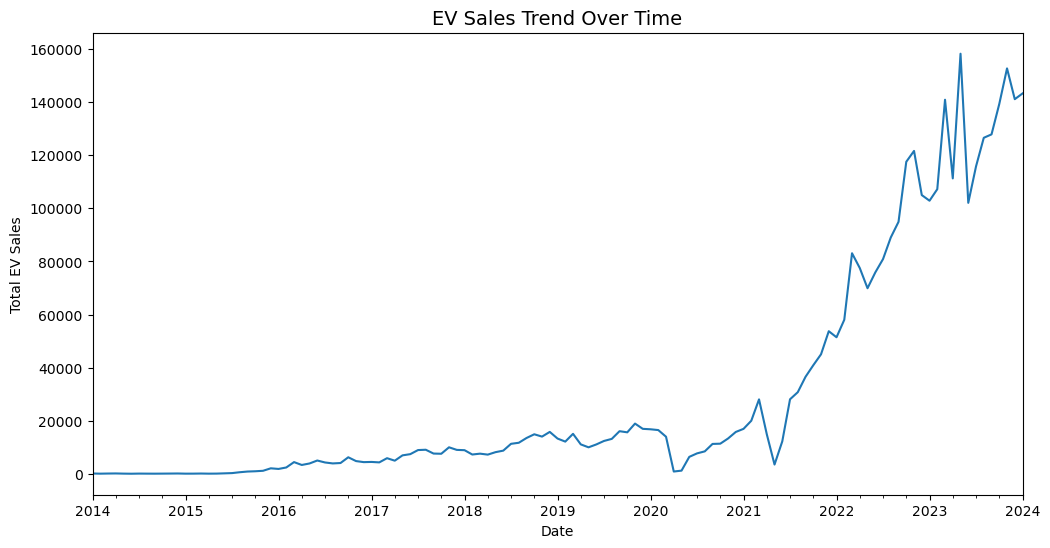

In [41]:
 ## 1. EV Sales Trend Over Time
# -----------------------------
plt.figure(figsize=(12,6))
df.groupby('Date')['EV_Sales_Quantity'].sum().plot()
plt.title("EV Sales Trend Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Total EV Sales")
plt.show()

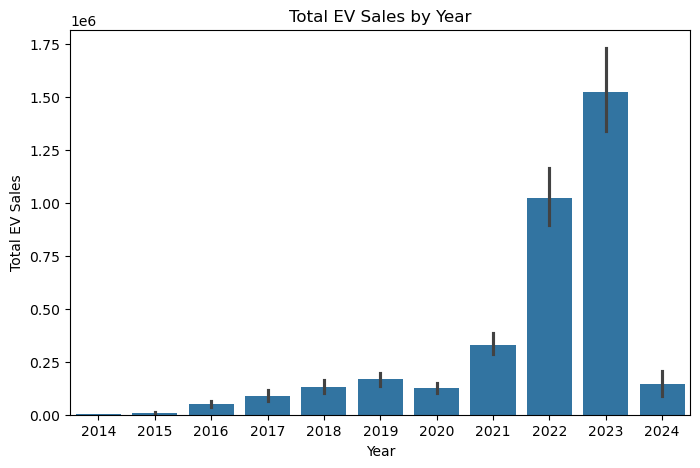

In [43]:
 # 2. EV Sales by Year
# -----------------------------
plt.figure(figsize=(8,5))
sns.barplot(x="Year", y="EV_Sales_Quantity", data=df, estimator=sum)
plt.title("Total EV Sales by Year")
plt.ylabel("Total EV Sales")
plt.show()

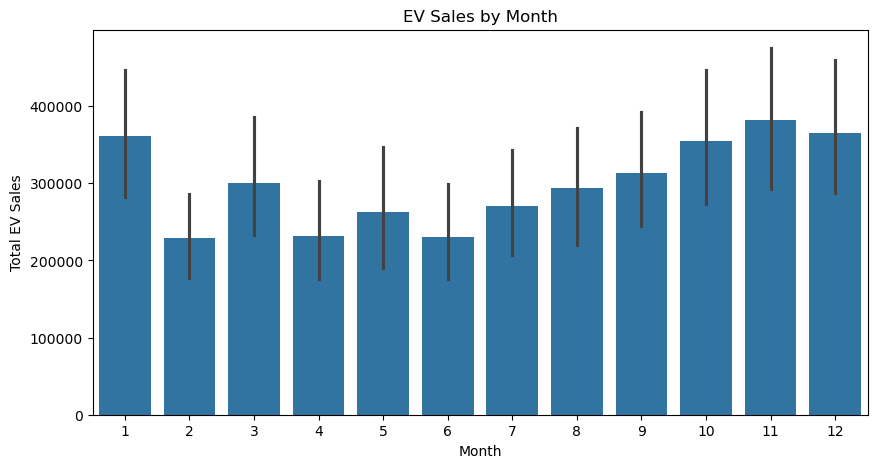

In [45]:
# 3. EV Sales by Month
# -----------------------------
plt.figure(figsize=(10,5))
sns.barplot(x="Month", y="EV_Sales_Quantity", data=df, estimator=sum)
plt.title("EV Sales by Month")
plt.ylabel("Total EV Sales")
plt.show()


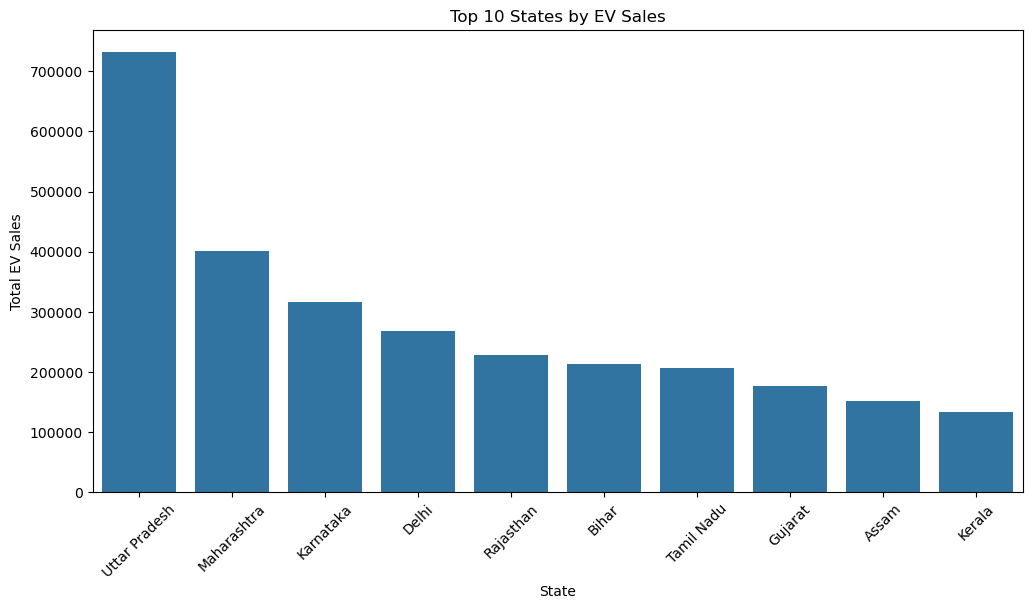

In [47]:
# 4. EV Sales by State (Top 10)
# -----------------------------
top_states = df.groupby('State')['EV_Sales_Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_states.index, y=top_states.values)
plt.title("Top 10 States by EV Sales")
plt.ylabel("Total EV Sales")
plt.xticks(rotation=45)
plt.show()

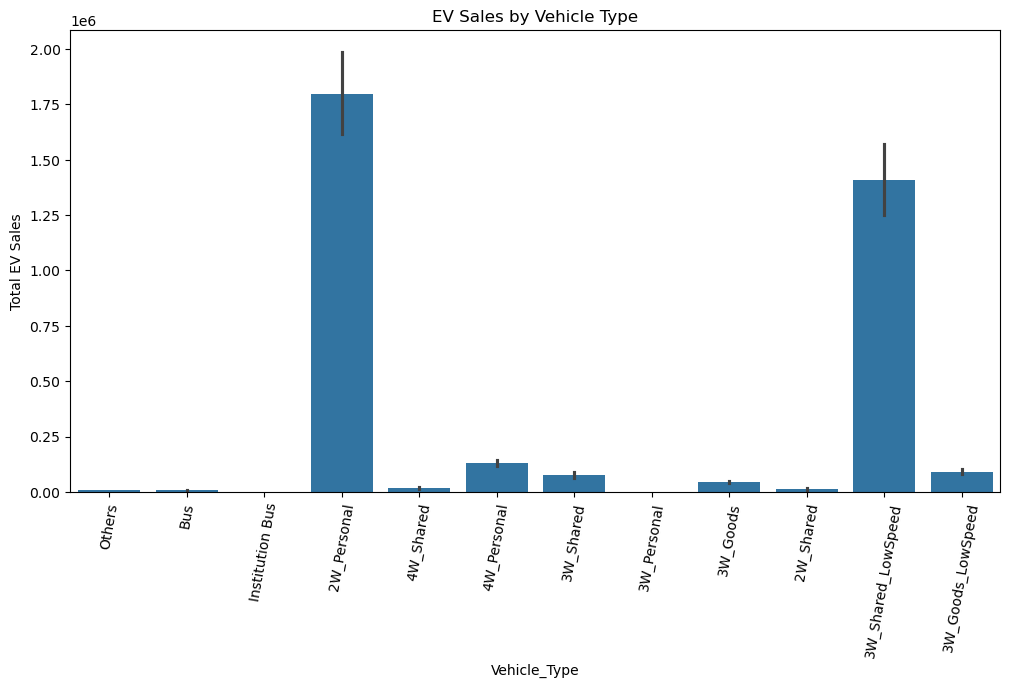

In [49]:
# 5. EV Sales by Vehicle Type
# -----------------------------
plt.figure(figsize=(12,6))
sns.barplot(x="Vehicle_Type", y="EV_Sales_Quantity", data=df, estimator=sum)
plt.title("EV Sales by Vehicle Type")

plt.ylabel("Total EV Sales")
# Rotate x-axis labels
plt.xticks(rotation=80)
plt.show()


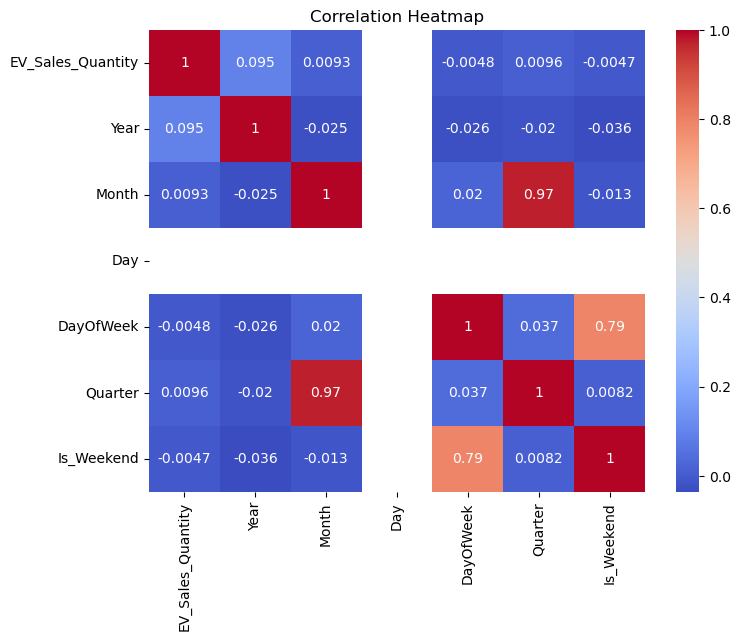

In [51]:
# 6. Correlation Heatmap
# -----------------------------
plt.figure(figsize=(8,6))
sns.heatmap(df[['EV_Sales_Quantity','Year','Month','Day','DayOfWeek','Quarter','Is_Weekend']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Step 4: Feature Engineering
# -----------------------------

from sklearn.preprocessing import LabelEncoder

# 1. Convert 'Date' column to datetime format (if not already done)
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


In [ ]:
df

In [ ]:
# 2. Create new features from 'Date'
df['Day'] = df['Date'].dt.day
df['Quarter'] = df['Date'].dt.quarter
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)


In [ ]:
df

In [ ]:
# 3. Encode categorical variables
cat_cols = ['State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type', 'Month_Name']

# Initialize LabelEncoder
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

print("Feature engineering completed. New columns added: Day, Quarter, WeekOfYear")
print(df.head())

In [ ]:
target = 'EV_Sales_Quantity'

# Drop columns that are redundant or for reference
X = df.drop([target, 'Date', 'Month_Name'], axis=1)  
y = df[target]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
categorical_features = ['State', 'Vehicle_Class', 'Vehicle_Category', 'Vehicle_Type']
numerical_features = [col for col in X.columns if col not in categorical_features]


In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [ ]:
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R^2 Score:", r2)


In [ ]:
coefs = model.named_steps['regressor'].coef_
feature_names = np.array(numerical_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()))
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
print(feature_importance)


In [ ]:
## Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R^2 Score:", r2)


In [ ]:
## visuliztion
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual EV Sales")
plt.ylabel("Predicted EV Sales")
plt.title("Actual vs Predicted EV Sales")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.show()


In [ ]:
residuals = y_test - y_pred

plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.show()

plt.scatter(y_pred, residuals, alpha=0.6)
plt.xlabel("Predicted EV Sales")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted EV Sales")
plt.axhline(0, color='r', linestyle='--')
plt.show()


In [ ]:
coefs = model.named_steps['regressor'].coef_
feature_names = np.array(numerical_features + list(model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()))
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs}).sort_values(by='Coefficient', ascending=False)
print(feature_importance)


In [ ]:
# By WeekOfYear
weekly_sales = df.groupby('WeekOfYear')['EV_Sales_Quantity'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(x='WeekOfYear', y='EV_Sales_Quantity', data=weekly_sales)
plt.title('EV Sales by Week of Year')
plt.show()

# Weekend vs Weekday
weekend_sales = df.groupby('Is_Weekend')['EV_Sales_Quantity'].sum().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x='Is_Weekend', y='EV_Sales_Quantity', data=weekend_sales)
plt.title('EV Sales: Weekend vs Weekday')
plt.show()


In [ ]:
sales_type = df.groupby('Vehicle_Type')['EV_Sales_Quantity'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='Vehicle_Type', y='EV_Sales_Quantity', data=sales_type, palette='coolwarm')
plt.title('EV Sales by Vehicle Type')
plt.show()


In [ ]:
sales_class = df.groupby('Vehicle_Class')['EV_Sales_Quantity'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10,5))
sns.barplot(x='Vehicle_Class', y='EV_Sales_Quantity', data=sales_class, palette='Set2')
plt.title('EV Sales by Vehicle Class')
plt.show()


In [ ]:
plt.figure(figsize=(8,5))
sns.lineplot(x='Year', y='EV_Sales_Quantity', data=df, marker='o', color='b')
plt.title('Yearly Analysis of EV Sales in India')
plt.xlabel('Year')
plt.ylabel('EV Sales')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(x='Month_Name', y='EV_Sales_Quantity', data=df, marker='o', color='r')
plt.title('Monthly Analysis of EV Sales in India')
plt.xlabel('Month')
plt.ylabel('EV Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(x='Vehicle_Class', y='EV_Sales_Quantity', data=df, palette='bright')
plt.title('Analysis by Vehicle Class')
plt.xlabel('Vehicle Class')
plt.ylabel('EV Sales')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x='Vehicle_Category', y='EV_Sales_Quantity', data=df, palette='bright')
plt.title('Analysis by Vehicle Category')
plt.xlabel('Vehicle Category')
plt.ylabel('EV Sales')
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(x='Vehicle_Type', y='EV_Sales_Quantity', data=df, palette='bright')
plt.title('Analysis by Vehicle Type')
plt.xlabel('Vehicle Type')
plt.ylabel('EV Sales')
plt.xticks(rotation=90)
plt.show()


In [ ]:
df.groupby('State')['EV_Sales_Quantity'].sum().sort_values(ascending=False).plot(kind='barh', figsize=(10,6))
